# Classification of real data

## Install required python modules

In [ ]:
%%bash
pip install -e ../.

In [ ]:
%%bash
pip install -r ../requirements.txt

## Import data

In [4]:
import numpy as np
from openpyxl import load_workbook
import pandas as pd


filename_data = '../data/Real_data/ST001706/1D/RCCdata.txt'
filename_status = '../data/Real_data/ST001706/RCC_samples.xlsx'
df_data = pd.DataFrame(np.loadtxt(filename_data, dtype=float))
df_status = pd.read_excel(filename_status, engine='openpyxl', header=None)

#Convert status into integers
df_status[0] = df_status[0].astype('category')
df_status = df_status.apply(lambda x: x.cat.codes)

In [5]:
print(df_data.shape)
print(df_status.shape)

(256, 32697)
(256, 1)


## Shuffle the data

In [6]:
from sklearn.utils import shuffle

df_status, df_data = shuffle(df_status, df_data)

## Split data into train and validation datasets

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df_data, df_status, stratify = df_status, test_size=0.2)

## Convert into tf.data

In [9]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train[0].tolist()))
val_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test[0].tolist()))

print(train_dataset.element_spec)
print(val_dataset.element_spec)

(TensorSpec(shape=(32697,), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))
(TensorSpec(shape=(32697,), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))


## Write tf.Record

In [39]:
from tfrecords import write_tfrecords

In [40]:
write_tfrecords('../data/tfrecords/Real_data/train', dataset=train_dataset, number=16)
write_tfrecords('../data/tfrecords/Real_data/validation', dataset=val_dataset, number=4)

## Read the tf.Record files

In [10]:
from tfrecords import read_tfrecords

In [11]:
train_file_paths = ['../data/tfrecords/Real_data/train/data_{}.tfrecord'.format(i) for i in range(16)]
train_dataset = read_tfrecords(train_file_paths)
train_dataset = train_dataset.batch(8).shuffle(300).prefetch(tf.data.experimental.AUTOTUNE)

val_file_paths = ['../data/tfrecords/Real_data/validation/data_{}.tfrecord'.format(i) for i in range(4)]
val_dataset = read_tfrecords(val_file_paths)
val_dataset = val_dataset.batch(8).prefetch(tf.data.experimental.AUTOTUNE)

## Define Checkpoint

In [12]:
from models import CheckpointCallback

ckpt_simple = CheckpointCallback("../saved_models/real_data/simple")
ckpt_regularised = CheckpointCallback("../saved_models/real_data/regularised")

## Define MLPs

In [53]:
from models import get_simple_mlp

simple_model = get_simple_mlp(input_shape=(32697,), hidden_units=[64, 64])
simple_model.summary()

Model: "functional_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 32697)]           0         
_________________________________________________________________
dense_59 (Dense)             (None, 64)                2092672   
_________________________________________________________________
dense_60 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_61 (Dense)             (None, 1)                 65        
Total params: 2,096,897
Trainable params: 2,096,897
Non-trainable params: 0
_________________________________________________________________


In [60]:
from models import get_regularised_bn_dropout_mlp

regularised_model = get_regularised_bn_dropout_mlp(input_shape=(32697,), hidden_units=[64, 64],
                                l2_reg_coeff=0.0001, dropout_rate=0.5)
regularised_model.summary()

Model: "functional_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 32697)]           0         
_________________________________________________________________
dense_64 (Dense)             (None, 64)                2092672   
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_65 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_66 (Dense)             (None, 1)                 65        
Total params: 2,096,897
Trainable params: 2,096,897
Non-trainable params: 0
___________________________________________

## Compile simple model

In [55]:
import tensorflow as tf
opt = tf.keras.optimizers.Adam(lr=0.0005)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
acc = tf.keras.metrics.BinaryAccuracy()
auc = tf.keras.metrics.AUC()
earlystopping = tf.keras.callbacks.EarlyStopping(patience=50)

In [56]:
simple_model.compile(optimizer=opt, loss=loss, metrics=[acc, auc])
simple_history = simple_model.fit(train_dataset, epochs=1000, validation_data=val_dataset,
                                  callbacks=[ckpt_simple, earlystopping])

Epoch 1/1000
24/24 [==============================] - 0s 13ms/step - loss: 0.6238 - binary_accuracy: 0.7292 - auc_5: 0.6851 - val_loss: 0.4182 - val_binary_accuracy: 0.7885 - val_auc_5: 0.8908
Epoch 2/1000
24/24 [==============================] - 0s 8ms/step - loss: 0.3198 - binary_accuracy: 0.8385 - auc_5: 0.9326 - val_loss: 0.3499 - val_binary_accuracy: 0.8462 - val_auc_5: 0.9176
Epoch 3/1000
24/24 [==============================] - 0s 6ms/step - loss: 0.1957 - binary_accuracy: 0.9271 - auc_5: 0.9798 - val_loss: 0.3433 - val_binary_accuracy: 0.7885 - val_auc_5: 0.9378
Epoch 4/1000
24/24 [==============================] - 0s 6ms/step - loss: 0.1562 - binary_accuracy: 0.9375 - auc_5: 0.9838 - val_loss: 0.3683 - val_binary_accuracy: 0.8462 - val_auc_5: 0.9437
Epoch 5/1000
24/24 [==============================] - 0s 6ms/step - loss: 0.1562 - binary_accuracy: 0.9167 - auc_5: 0.9855 - val_loss: 0.3443 - val_binary_accuracy: 0.8846 - val_auc_5: 0.9319
Epoch 6/1000
24/24 [===================

## Plot the learning curves

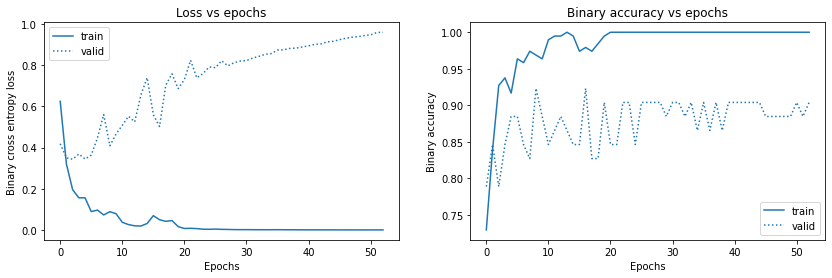

{'loss': 0.9587621092796326, 'binary_accuracy': 0.9038461446762085, 'auc_5': 0.887394905090332}


In [57]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14, 4))

fig.add_subplot(121)
plt.plot(simple_history.history['loss'], label='train', color='C0', linestyle='-')
plt.plot(simple_history.history['val_loss'], label='valid', color='C0', linestyle=':')
plt.title("Loss vs epochs")
plt.xlabel("Epochs")
plt.ylabel("Binary cross entropy loss")
plt.legend()

fig.add_subplot(122)
plt.plot(simple_history.history['binary_accuracy'], label='train', color='C0', linestyle='-')
plt.plot(simple_history.history['val_binary_accuracy'], label='valid', color='C0', linestyle=':')
plt.title("Binary accuracy vs epochs")
plt.xlabel("Epochs")
plt.ylabel("Binary accuracy")
plt.legend()

plt.show()
print(simple_model.evaluate(val_dataset, return_dict=True, verbose=0))

## Compile regularized model

In [61]:
import tensorflow as tf
opt = tf.keras.optimizers.Adam(lr=0.0005)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
acc = tf.keras.metrics.BinaryAccuracy()
auc = tf.keras.metrics.AUC()
earlystopping = tf.keras.callbacks.EarlyStopping(patience=50)

In [62]:
regularised_model.compile(optimizer=opt, loss=loss, metrics=[acc, auc])
regularised_history = regularised_model.fit(train_dataset, epochs=1000, validation_data=val_dataset,
                                                       callbacks=[ckpt_regularised, earlystopping])

Epoch 1/1000
24/24 [==============================] - 0s 13ms/step - loss: 0.9372 - binary_accuracy: 0.6146 - auc_7: 0.5994 - val_loss: 0.7307 - val_binary_accuracy: 0.7308 - val_auc_7: 0.8252
Epoch 2/1000
24/24 [==============================] - 0s 7ms/step - loss: 0.8622 - binary_accuracy: 0.6562 - auc_7: 0.6838 - val_loss: 0.5191 - val_binary_accuracy: 0.7500 - val_auc_7: 0.9067
Epoch 3/1000
24/24 [==============================] - 0s 8ms/step - loss: 0.6352 - binary_accuracy: 0.7760 - auc_7: 0.7841 - val_loss: 0.5638 - val_binary_accuracy: 0.7692 - val_auc_7: 0.9303
Epoch 4/1000
24/24 [==============================] - 0s 6ms/step - loss: 0.6033 - binary_accuracy: 0.7604 - auc_7: 0.7937 - val_loss: 0.3397 - val_binary_accuracy: 0.8462 - val_auc_7: 0.9336
Epoch 5/1000
24/24 [==============================] - 0s 7ms/step - loss: 0.4781 - binary_accuracy: 0.8177 - auc_7: 0.8585 - val_loss: 0.4563 - val_binary_accuracy: 0.7692 - val_auc_7: 0.9244
Epoch 6/1000
24/24 [===================

## Plot the learning curves

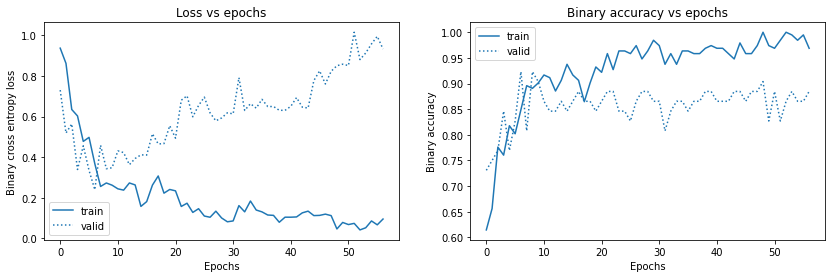

{'loss': 1.373565912246704, 'binary_accuracy': 0.8846153616905212, 'auc_2': 0.8915966749191284}


In [63]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14, 4))

fig.add_subplot(121)
plt.plot(regularised_history.history['loss'], label='train', color='C0', linestyle='-')
plt.plot(regularised_history.history['val_loss'], label='valid', color='C0', linestyle=':')
plt.title("Loss vs epochs")
plt.xlabel("Epochs")
plt.ylabel("Binary cross entropy loss")
plt.legend()

fig.add_subplot(122)
plt.plot(regularised_history.history['binary_accuracy'], label='train', color='C0', linestyle='-')
plt.plot(regularised_history.history['val_binary_accuracy'], label='valid', color='C0', linestyle=':')
plt.title("Binary accuracy vs epochs")
plt.xlabel("Epochs")
plt.ylabel("Binary accuracy")
plt.legend()

plt.show()
print(regularised_bn_dropout_model.evaluate(val_dataset, return_dict=True, verbose=0))

## Load saved models

In [92]:
from models import get_simple_mlp
import tensorflow as tf


simple_model = get_simple_mlp(input_shape=(32697,), hidden_units=[64, 64])
regularised_model = get_regularised_bn_dropout_mlp(input_shape=(32697,), hidden_units=[64, 64],
                                l2_reg_coeff=0.0001, dropout_rate=0.5)
opt = tf.keras.optimizers.Adam(lr=0.0005)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
acc = tf.keras.metrics.BinaryAccuracy()
auc = tf.keras.metrics.AUC(name='auc')
sensitivity = tf.keras.metrics.Recall(name='recall')
simple_model.compile(optimizer=opt, loss=loss, metrics=[acc, auc, sensitivity])
regularised_model.compile(optimizer=opt, loss=loss, metrics=[acc, auc, sensitivity])
simple_status = (tf.train.Checkpoint(model=simple_model)
                 .restore(tf.train.latest_checkpoint('../saved_models/real_data/simple'))
                 .expect_partial())
simple_status.assert_existing_objects_matched()
regularised_status = (tf.train.Checkpoint(model=regularised_model)
                 .restore(tf.train.latest_checkpoint('../saved_models/real_data/regularised'))
                 .expect_partial())
regularised_status.assert_existing_objects_matched()
print(simple_model.evaluate(val_dataset, return_dict=True, verbose=0))
print(regularised_model.evaluate(val_dataset, return_dict=True, verbose=0))

{'loss': 0.34328901767730713, 'binary_accuracy': 0.7884615659713745, 'auc': 0.9378150701522827, 'recall': 0.8823529481887817}
{'loss': 0.2403372824192047, 'binary_accuracy': 0.8557692170143127, 'auc': 0.9485294222831726, 'recall': 0.8823529481887817}


## Plot examples with predictions

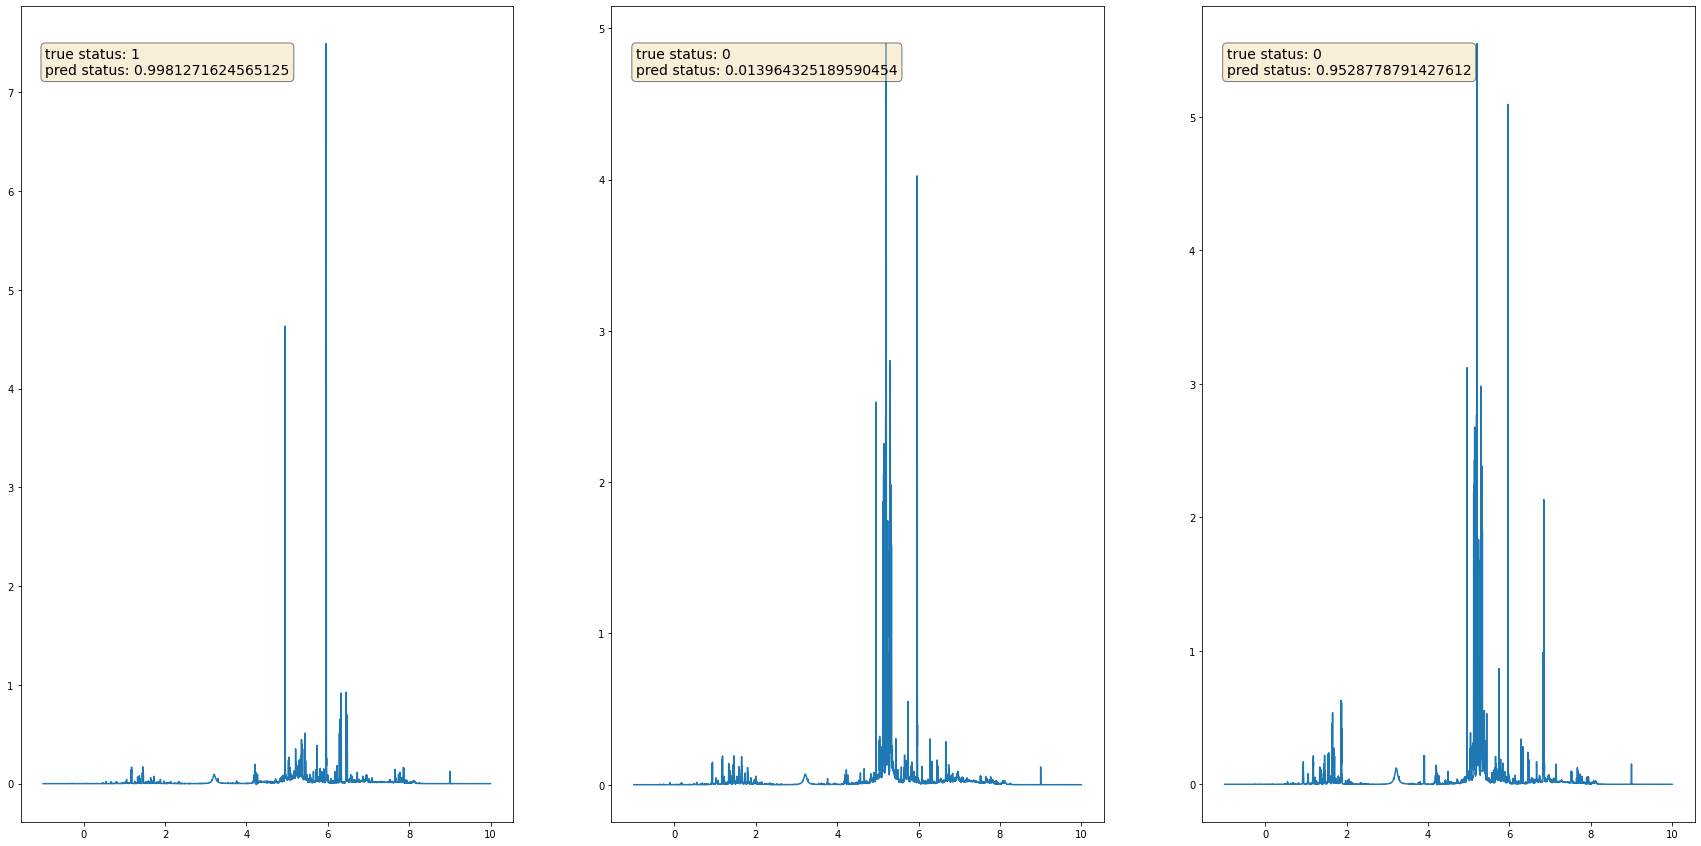

In [68]:
#Plot samples
import matplotlib.pyplot as plt
import numpy as np

for parsed_record in val_dataset.shuffle(10).take(1):
    data_points_0 = parsed_record[0][0]
    data_points_1 = parsed_record[0][1]
    data_points_2 = parsed_record[0][2]
    true_status_0 = parsed_record[1][0].numpy()
    true_status_1 = parsed_record[1][1].numpy()
    true_status_2 = parsed_record[1][2].numpy()
    pred_status_0 = simple_model.predict(parsed_record[0])[0][0]
    pred_status_1 = simple_model.predict(parsed_record[0])[1][0]
    pred_status_2 = simple_model.predict(parsed_record[0])[2][0]


import matplotlib.pyplot as plt

label_0 = '\n'.join((
    r'true status: {}'.format(true_status_0),
    r'pred status: {}'.format(pred_status_0)))

label_1 = '\n'.join((
    r'true status: {}'.format(true_status_1),
    r'pred status: {}'.format(pred_status_1)))

label_2 = '\n'.join((
    r'true status: {}'.format(true_status_2),
    r'pred status: {}'.format(pred_status_2)))

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)



n_rows, n_cols = 1, 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(30, 15))
x_axis_0 = np.linspace(-1, 10, num=data_points_0.shape[0])
x_axis_1 = np.linspace(-1, 10, num=data_points_1.shape[0])
x_axis_2 = np.linspace(-1, 10, num=data_points_2.shape[0])
axes[0].plot(x_axis_0, data_points_0)
axes[1].plot(x_axis_1, data_points_1)
axes[2].plot(x_axis_2, data_points_2)

# place a text box in upper left in axes coords
axes[0].text(0.05, 0.95, label_0, transform=axes[0].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
axes[1].text(0.05, 0.95, label_1, transform=axes[1].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
axes[2].text(0.05, 0.95, label_2, transform=axes[2].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.show()

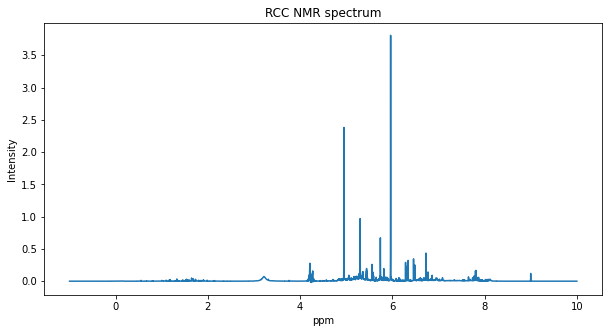

In [19]:
for parsed_record in val_dataset.take(1):
    data_points_0 = parsed_record[0][0]
x_axis_0 = np.linspace(-1, 10, num=data_points_0.shape[0])
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(x_axis_0, data_points_0)
plt.title('RCC NMR spectrum')
plt.xlabel('ppm')
plt.ylabel('Intensity')
plt.show()

## Try random forest

### Train the model

In [96]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(1000, oob_score=True)
clf.fit(X_train, y_train[0])

RandomForestClassifier(n_estimators=1000, oob_score=True)

### Save the model

In [97]:
import joblib
joblib.dump(clf, '../saved_models/real_data/rf')

['../saved_models/real_data/rf']

### Load the model

In [98]:
loaded_rf = joblib.load('../saved_models/real_data/rf')

### Performance

In [114]:
from sklearn.metrics import roc_auc_score, confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_test[0], loaded_rf.predict(X_test)).ravel()

print('Accuracy: ', loaded_rf.score(X_test, y_test[0]))
print('Specificity: ', tn / (tn+fp))
print('AUC: ', roc_auc_score(y_test[0], loaded_rf.predict_proba(X_test)[:,1]))

Accuracy:  0.8846153846153846
Specificity:  1.0
AUC:  0.9882352941176471
